# Neural network based integrator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from dynamical_system import *
from time_integrator import *
from nn_integrator import *
%matplotlib inline

np.random.seed(2512517)

## Neural network integrators
Let $q(t)=(x(t),p(t))\in\mathbb{R}^{2d}$ be the state vector. Two methods are implemented to advance this state vector in time:

### Multistep neural network
The `MultistepNNIntegrator` class is used to implement a neural network based integrator with a $S$-step method. This is integrating a given $d$-dimensional system $\frac{dq(t)}{dt}=\mathcal{N}(q(t))$. The underlying neural model implements the mapping

$$
q^{(t-(S-1)\Delta t)},\dots,q^{(t-\Delta t)},q^{(t)} \mapsto q^{(t+\Delta t)}
$$

Internally this is realised by mapping the $B\times S \times d$ tensor $X$ to the $B\times d$ tensor $y$, where $B$ is the minibatch-size. This mapping is of the following form:

$$
y_{b,j} = X_{b,S-1,j} + \Delta t \cdot \Phi_{bj}(X)
$$

where $\Phi$ is a dense neural network. Note that for each batch index $b$, $X_{b,S-1,\cdot}$ is simply the vector $q^{(t)}_b$, i.e. we assume that $q^{(t+\Delta t)}$ is $q^{(t)}$ plus $\Delta t$ times some correction. The neural network $\Phi$ can take different form:
* it can simply be a set of dense layers or
* it can be a two-layer LSTM network, followed by a dense layer as in [https://arxiv.org/abs/2004.06493](https://arxiv.org/abs/2004.06493)

### Hamiltonian neural network integrator
Alternatively, the `HamiltonianNNIntegrator` implements a single-step Stoermer-Verlet method for a Hamiltonian system, following the ideas in [https://arxiv.org/abs/1906.01563](https://arxiv.org/abs/1906.01563). In this case the update $q^{(t)}\mapsto q^{(t+\Delta t)}$ takes the form:

$$
\begin{aligned}
p^{(t+\Delta t/2)} &= p^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t)}\right)\\[1ex]
x^{(t+\Delta t)} &= x^{(t)} + \Delta t \frac{\partial T}{\partial p}\left(p^{(t+\Delta t/2)}\right)\\[1ex]
p^{(t+\Delta t)} &= p^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t+\Delta t)}\right)
\end{aligned}
$$

Assuming that the Hamiltonian $H(x,p) = T(p) + V(x)$ is separable, the kinetic energy $T(p)$ and potential energy $V(x)$ are represented by neural networks.

### Set up system
Set system parameters, construct dynamical system and integrator.

The timestep size of the Neural network integrator is set to $\Delta t=40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

In [2]:
#system_label = 'harmonic oscillator'
system_label = 'coupled pendulums'
if system_label == 'harmonic oscillator':
    # mass of particle
    mass = 1.2
    # spring constant
    k_spring = 0.9
    dynamical_system = HarmonicOscillator(mass,k_spring)
elif system_label == 'coupled pendulums':
    # mass of particle
    mass = 1.0
    # length of rods
    L_rod = 1.0
    # distance of anchor points
    d_anchor = 1.0
    # spring constant
    k_spring = 1.0
    dynamical_system = CoupledPendulums(mass,L_rod,d_anchor,k_spring) 
else:
    print(f'ERROR: unknown dynamical system: \"{system_label}\"')

# timestep for training integrator
dt_train = 0.005
# timestep for neural network integrator
dt = 0.2
# number of steps for multistep neural network integrator
nsteps = 6
# re-train model?
re_train = False

# use Hamiltonian model?
use_hamiltonian = True
# use LSTM network for multistep integrator?
use_LSTM = False
# use exact integrator for training?
use_exact_integrator=False
# Use Strang splitting?
use_strang_splitting=True

# Integrator used to generate data
if use_exact_integrator:
    train_integrator = ExactIntegrator(dynamical_system,dt_train)
else:
    train_integrator = VerletIntegrator(dynamical_system,dt_train)

BATCH_SIZE=64
EPOCHS=1000
STEPS_PER_EPOCH=1000

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=EPOCHS*STEPS_PER_EPOCH,
    alpha=1.E-3)

if use_hamiltonian:
    if use_strang_splitting:
        pass
        H_layers = [keras.layers.Dense(128,activation='tanh'),
                    keras.layers.Dense(64,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]
        nn_integrator = HamiltonianStrangSplittingNNIntegrator(dynamical_system,dt,H_layers,
                                                               learning_rate=learning_rate)
    else:
        V_pot_layers = [keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]
        T_kin_layers = [keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]
        nn_integrator = HamiltonianVerletNNIntegrator(dynamical_system,dt,V_pot_layers,T_kin_layers,
                                                      V_pot_layer_weights=None,T_kin_layer_weights=None,
                                                      learning_rate=learning_rate)

else:
    if use_LSTM: 
        # Use two layers of LSTMs followed by a dense layer
        dense_layers = [keras.layers.LSTM(64,return_sequences=True),
                        keras.layers.LSTM(64),
                        keras.layers.Dense(32,activation='tanh')]
    else:
        # Just use several dense layers
        dense_layers = [keras.layers.Flatten(),
                        keras.layers.Dense(32,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]


    nn_integrator = MultistepNNIntegrator(dynamical_system,dt,nsteps,
                                          dense_layers,
                                          learning_rate=learning_rate)

# visualise the neural network model
nn_integrator.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 strang_splitting_model (Str  (None, 4)                11008     
 angSplittingModel)                                              
                                                                 
Total params: 11,008
Trainable params: 11,008
Non-trainable params: 0
_________________________________________________________________


## Data generator
The following data generator class can be used to construct training data samples of the form $(X_j,y_j)$ where

$$
X_j = q_j^{(0)},q_j^{(\Delta t)},\dots,q_j^{((S-1)\Delta t)},\qquad\qquad y_j = q_j^{(S\Delta t)}.
$$

Here $q_j^{(0)}$ is a randomly chosen initial condition and the states $q_j^{(\Delta t)},q_j^{(2\Delta t)},\dots,q_j^{((S-1)\Delta t)}, q_j^{(S\Delta t)}$ are generated with a training generator (=Verlet) that is run with a smaller timestep.

In [3]:
class DataGenerator(object):
    def __init__(self,nn_integrator,train_integrator):        
        self.nn_integrator = nn_integrator
        self.train_integrator = train_integrator
        self.dynamical_system = self.nn_integrator.dynamical_system
        self.dataset = tf.data.Dataset.from_generator(self._generator,                                                      
                                                      output_signature=(
                                                          tf.TensorSpec(shape=(self.nn_integrator.nsteps,
                                                                               2*self.dynamical_system.dim), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(2*self.dynamical_system.dim), dtype=tf.float32)
                                                      ))
    
    def _generator(self):
        state = np.zeros((self.nn_integrator.nsteps+1,2*self.dynamical_system.dim))
        while True:
            self.dynamical_system.set_random_state(state[0,:self.dynamical_system.dim],
                                                   state[0,self.dynamical_system.dim:])
            self.train_integrator.set_state(state[0,:self.dynamical_system.dim],
                                            state[0,self.dynamical_system.dim:])
            for k in range(self.nn_integrator.nsteps):
                self.train_integrator.integrate(int(self.nn_integrator.dt/self.train_integrator.dt))
                state[k+1,:self.dynamical_system.dim] = self.train_integrator.q[:]
                state[k+1,self.dynamical_system.dim:] = self.train_integrator.p[:]
            X = state[:-1,:]
            y = state[-1,:]
            yield (X,y)
    
data_generator = DataGenerator(nn_integrator,train_integrator)

## Train neural network based integrator

Note that training history can be visualised with tensorboard:

```
tensorboard --logdir=./tb_logs
```

In [4]:
log_dir = './tb_logs/'
train_batches = data_generator.dataset.batch(BATCH_SIZE)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result = nn_integrator.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)

Epoch 1/1000
1000/1000 [==============================] - 15s 14ms/step - loss: 0.0322
Epoch 2/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.7034e-04
Epoch 3/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 2.4296e-04
Epoch 4/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 2.0370e-04
Epoch 5/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 1.7551e-04
Epoch 6/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 1.6682e-04
Epoch 7/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 1.5733e-04
Epoch 8/1000
1000/1000 [==============================] - 15s 15ms/step - loss: 1.4449e-04
Epoch 9/1000
1000/1000 [==============================] - 15s 15ms/step - loss: 1.3389e-04
Epoch 10/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 1.3795e-04
Epoch 11/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 1.3173e-04
E

1000/1000 [==============================] - 14s 14ms/step - loss: 8.2673e-05
Epoch 90/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 8.0503e-05
Epoch 91/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 8.2647e-05
Epoch 92/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 8.0793e-05
Epoch 93/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 8.4145e-05
Epoch 94/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 7.8733e-05
Epoch 95/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 7.7921e-05
Epoch 96/1000
1000/1000 [==============================] - 15s 15ms/step - loss: 8.1746e-05
Epoch 97/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 8.1141e-05
Epoch 98/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 7.7778e-05
Epoch 99/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 8.2495e-05
Ep

1000/1000 [==============================] - 14s 14ms/step - loss: 6.7859e-05
Epoch 178/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.5740e-05
Epoch 179/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.8141e-05
Epoch 180/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.7007e-05
Epoch 181/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.7617e-05
Epoch 182/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.6627e-05
Epoch 183/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.7692e-05
Epoch 184/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.5591e-05
Epoch 185/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.5607e-05
Epoch 186/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.8065e-05
Epoch 187/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 6.6

1000/1000 [==============================] - 14s 14ms/step - loss: 5.9147e-05
Epoch 266/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.8296e-05
Epoch 267/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.8080e-05
Epoch 268/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.9778e-05
Epoch 269/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.9902e-05
Epoch 270/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 5.7382e-05
Epoch 271/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 6.1106e-05
Epoch 272/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 5.8046e-05
Epoch 273/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.8414e-05
Epoch 274/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 5.9387e-05
Epoch 275/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 5.8

1000/1000 [==============================] - 14s 14ms/step - loss: 5.3400e-05
Epoch 354/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.4654e-05
Epoch 355/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.4097e-05
Epoch 356/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.1852e-05
Epoch 357/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.4081e-05
Epoch 358/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.2377e-05
Epoch 359/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.3855e-05
Epoch 360/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 5.2864e-05
Epoch 361/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.3097e-05
Epoch 362/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.3189e-05
Epoch 363/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.3

1000/1000 [==============================] - 14s 14ms/step - loss: 4.9695e-05
Epoch 442/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.9504e-05
Epoch 443/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.8341e-05
Epoch 444/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.8395e-05
Epoch 445/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 5.0756e-05
Epoch 446/1000
1000/1000 [==============================] - 15s 15ms/step - loss: 4.8117e-05
Epoch 447/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.9068e-05
Epoch 448/1000
1000/1000 [==============================] - 15s 15ms/step - loss: 4.9839e-05
Epoch 449/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.9184e-05
Epoch 450/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.7564e-05
Epoch 451/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.8

1000/1000 [==============================] - 14s 14ms/step - loss: 4.5602e-05
Epoch 530/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.4873e-05
Epoch 531/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.4962e-05
Epoch 532/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 4.4598e-05
Epoch 533/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.5497e-05
Epoch 534/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.4522e-05
Epoch 535/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 4.4073e-05
Epoch 536/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.5339e-05
Epoch 537/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.5340e-05
Epoch 538/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.5406e-05
Epoch 539/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.5

1000/1000 [==============================] - 14s 14ms/step - loss: 4.2483e-05
Epoch 618/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.1986e-05
Epoch 619/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.3052e-05
Epoch 620/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.1932e-05
Epoch 621/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 4.1843e-05
Epoch 622/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 4.1684e-05
Epoch 623/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.1839e-05
Epoch 624/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.2086e-05
Epoch 625/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.1153e-05
Epoch 626/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 4.1781e-05
Epoch 627/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 4.1

1000/1000 [==============================] - 14s 14ms/step - loss: 3.9808e-05
Epoch 706/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.9817e-05
Epoch 707/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 3.9479e-05
Epoch 708/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.9503e-05
Epoch 709/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.8602e-05
Epoch 710/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 3.9490e-05
Epoch 711/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 3.9543e-05
Epoch 712/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 3.9156e-05
Epoch 713/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.9943e-05
Epoch 714/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 3.8356e-05
Epoch 715/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.9

1000/1000 [==============================] - 14s 14ms/step - loss: 3.7620e-05
Epoch 794/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7841e-05
Epoch 795/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7176e-05
Epoch 796/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7589e-05
Epoch 797/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7615e-05
Epoch 798/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7225e-05
Epoch 799/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 3.7736e-05
Epoch 800/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7605e-05
Epoch 801/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7413e-05
Epoch 802/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7051e-05
Epoch 803/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.7

1000/1000 [==============================] - 14s 14ms/step - loss: 3.6028e-05
Epoch 882/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5935e-05
Epoch 883/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.6037e-05
Epoch 884/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.6123e-05
Epoch 885/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 3.5815e-05
Epoch 886/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.6024e-05
Epoch 887/1000
1000/1000 [==============================] - 13s 13ms/step - loss: 3.6431e-05
Epoch 888/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.6079e-05
Epoch 889/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5963e-05
Epoch 890/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5634e-05
Epoch 891/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5

1000/1000 [==============================] - 13s 13ms/step - loss: 3.5202e-05
Epoch 970/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5655e-05
Epoch 971/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5465e-05
Epoch 972/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5300e-05
Epoch 973/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.4938e-05
Epoch 974/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5744e-05
Epoch 975/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.4979e-05
Epoch 976/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5044e-05
Epoch 977/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5246e-05
Epoch 978/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5214e-05
Epoch 979/1000
1000/1000 [==============================] - 14s 14ms/step - loss: 3.5

## Visualise loss history

Plot the loss history for both the vanilla dense network and the LSTM network.

In [5]:
nn_integrator.save_model('trained_models/coupled_pendulums/hamiltonian_strang_splitting_40x')

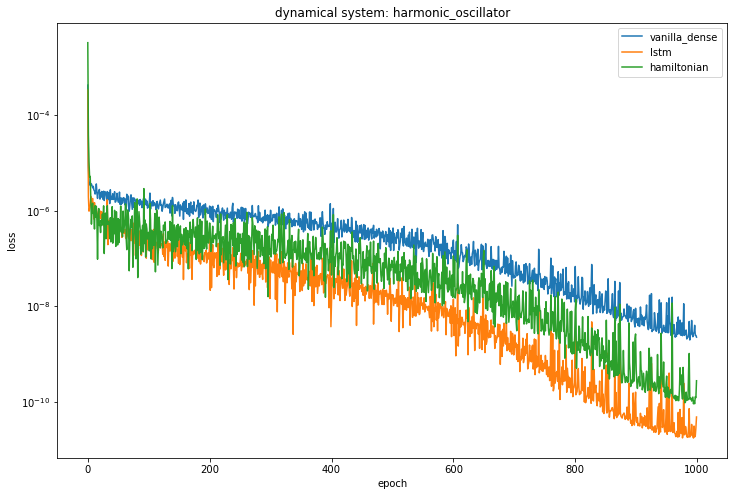

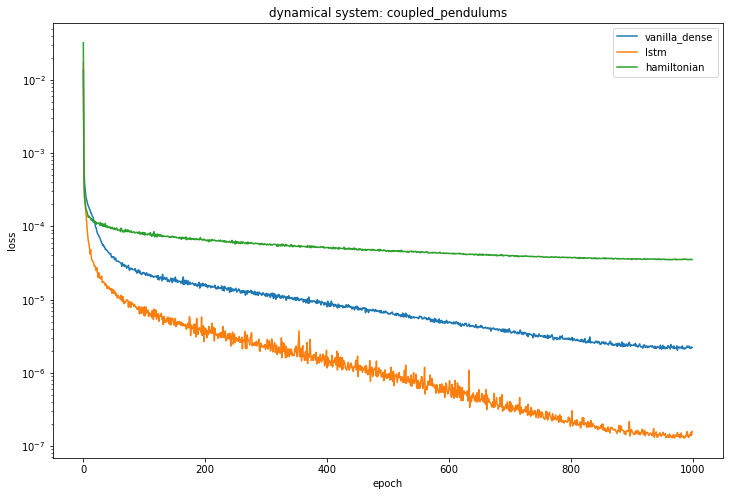

In [8]:
import pandas as pd
modelnames = ('vanilla_dense', 'lstm','hamiltonian')
systemnames = ('harmonic_oscillator','coupled_pendulums')
for systemname in systemnames:
    plt.figure(figsize=(12, 8))
    for modelname in modelnames:
        steps = ('' if 'hamiltonian' in modelname else '_6steps')
        filename = 'loss_history_'+systemname+'_'+modelname+'_40x'+steps+'.csv'
        data = pd.read_csv(filename)
        X = data['Step'].to_numpy()
        Y = data['Value'].to_numpy()
        plt.title('dynamical system: '+systemname)
        plt.plot(X,Y,label=modelname)
    ax = plt.gca()
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_yscale('log')
    plt.legend(loc='upper right')
    plt.show()

## Plot trajectories and energy drift

Visualise the position $x(t)$ and the position error $x(t)-x_{\text{exact}}(t)$ for the following setups:

1. Verlet integrator with timestep $\Delta t_{\text{train}}$
2. Coarse Verlet integrator with timestep $\Delta t = 40\Delta t_{\text{train}}$
3. Vanilla dense network with timestep $\Delta t = 40\Delta t_{\text{train}}$
4. LSTM network with timestep $\Delta t = 40\Delta t_{\text{train}}$

For all four setups, also visualise the energy drift $E(t)-E(t=0)$.

Note that this will load the trained models from disk, so this will only work if you have these files (I didn't commit them to the repository since they are very large).

In [10]:
# Final time
T_final = 48

# Initial conditions
q0 = np.zeros(dynamical_system.dim)
p0 = np.zeros(dynamical_system.dim)
if system_label == 'coupled pendulums':
    q0[:] = (1, 0)
    p0[:] = (0, 0)
else:
    q0[:] = 1
    p0[:] = 1
verlet_integrator = VerletIntegrator(dynamical_system,dt_train)
verlet_integrator.set_state(q0,p0)
if system_label == 'coupled pendulums':
    exact_integrator = VerletIntegrator(dynamical_system,dt_train)
else:
    exact_integrator = ExactIntegrator(dynamical_system,dt_train)
exact_integrator.set_state(q0,p0)

# ==== Verlet- and exact integrator ====
t0 = 0.0
t = {} # times
q = {} # positions
E = {} # energies
dq = {} # position errors
t['exact'] = []
t['verlet'] = []
q['exact'] = []
q['verlet'] = []
E['exact'] = []
E['verlet'] = []
dq['verlet'] = []
while t0<T_final:
    t['exact'].append(t0)
    t['verlet'].append(t0)
    E['exact'].append(exact_integrator.energy())
    q['exact'].append(exact_integrator.q[0])
    E['verlet'].append(verlet_integrator.energy())
    q['verlet'].append(verlet_integrator.q[0])
    dq['verlet'].append(verlet_integrator.q[0]-exact_integrator.q[0])
    verlet_integrator.integrate(1)
    exact_integrator.integrate(1)
    t0 += dt_train

# Verlet with large timestep

t['verlet coarse'] = []
q['verlet coarse'] = []
E['verlet coarse'] = []
dq['verlet coarse'] = []
coarse_verlet_integrator = VerletIntegrator(dynamical_system,dt)
coarse_verlet_integrator.set_state(q0,p0)
exact_integrator.set_state(q0,p0)
t0 = 0.0
nsteps = int(dt/dt_train)
while t0<T_final:
    t['verlet coarse'].append(t0)
    E['verlet coarse'].append(coarse_verlet_integrator.energy())
    q['verlet coarse'].append(coarse_verlet_integrator.q[0])
    dq['verlet coarse'].append(coarse_verlet_integrator.q[0]-exact_integrator.q[0])
    coarse_verlet_integrator.integrate(1)
    exact_integrator.integrate(nsteps)
    t0 += dt

# ==== Neural network integrators ====

if system_label == 'coupled pendulums':
    directory = 'trained_models/coupled_pendulums/'    
else:
    directory = 'trained_models/harmonic_oscillator/'
models = {'vanilla dense':keras.models.load_model(directory+'vanilla_dense_40x_6steps'),
          'LSTM':keras.models.load_model(directory+'lstm_40x_6steps'),
          'Hamiltonian':HamiltonianStrangSplittingNNIntegrator.load_model(directory+'hamiltonian_strang_splitting_40x')}
for label,model in models.items():
    nn_integrator = NNIntegrator.from_model(dynamical_system,dt,model)
    # Initialise with exact integrator
    q_initial = np.zeros((nn_integrator.nsteps,dynamical_system.dim))
    p_initial = np.zeros((nn_integrator.nsteps,dynamical_system.dim))
    exact_integrator.set_state(q0,p0)
    for k in range(nn_integrator.nsteps):    
        q_initial[k,:] = exact_integrator.q[:]
        p_initial[k,:] = exact_integrator.p[:]
        exact_integrator.integrate(int(dt/dt_train))
        nsteps += 1
    nn_integrator.set_state(q_initial,p_initial)
    t0 = (nn_integrator.nsteps-1)*nn_integrator.dt
    
    # Timestepping loop
    t[label] = []
    q[label] = []
    E[label] = []
    dq[label] = []
    nsteps = (nn_integrator.nsteps-1)*int(dt/dt_train)
    while t0<T_final:
        t[label].append(t0)
        q_nn = nn_integrator.q[0]
        exact_integrator.set_state(q0,p0)
        exact_integrator.integrate(nsteps)
        q_exact = exact_integrator.q[0]
        q[label].append(q_nn)
        dq[label].append(q_nn-q_exact)
        E[label].append(nn_integrator.energy())
        nn_integrator.integrate(1)
        t0 += dt
        nsteps += int(dt/dt_train)

# Plot position as a function of time
fig, axs = plt.subplots(5,2,figsize=(12, 8))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM','Hamiltonian')):
    ax = axs[j][0] 
    ax.plot(t['exact'],q['exact'],label='exact',color='blue')
    ax.plot(t[label],q[label],label=label,color='red')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)$')
    if j==0:
        ax.set_title('Position')
    ax = axs[j][1] 
    ax.plot(t[label],np.asarray(dq[label]),label=label,color='blue')
    ax.legend(loc='lower left')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)-x_{\text{exact}}(t)$')
    ax.yaxis.set_label_position("right")
    if j==0:
        ax.set_title('Position error')
plt.show()

plt.clf()
fig, axs = plt.subplots(5,1,figsize=(12, 8))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM','Hamiltonian')):
    ax = axs[j]
    ax.plot(t[label],np.asarray(E[label])-E[label][0],label=label,color='blue')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$E(t)-E(t_0)$')
    if j==0:
        ax.set_title('Energy drift')
plt.show()

ValueError: You called `set_weights(weights)` on layer "dense" with a weight list of length 2, but the layer was expecting 0 weights. Provided weights: [array([[-3.63025844e-01,  3.10110613e-06,  5.3212...

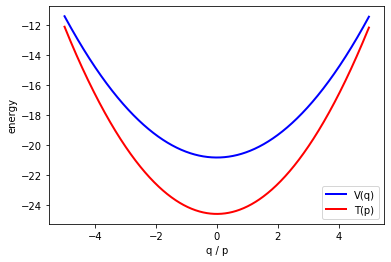

In [12]:
# Plot potential and kinetic energy (for debugging, can only be used with Hamiltonian network)
model = HamiltonianVerletNNIntegrator.load_model('trained_models/harmonic_oscillator/hamiltonian_40x')
    
X = tf.expand_dims(tf.constant(np.arange(-5.0,+5.0,0.01)),axis=1)

V_pot = model.layers[-1].V_pot(X).numpy().flatten()
T_kin = model.layers[-1].T_kin(X).numpy().flatten()
plt.plot(X,V_pot,linewidth=2,color='blue',label='V(q)')
plt.plot(X,T_kin,linewidth=2,color='red',label='T(p)')
ax = plt.gca()
ax.set_xlabel('q / p')
ax.set_ylabel('energy')
ax.legend(loc='lower right')
plt.show()